Occasionally, you might find yourself toying with a `keras` application that's sufficiently complicated to merit graduating from the vanilla, `Sequential()` API to doing things functionally. While the expressiveness that this allows is immediately desirable for the sake of creativity, keeping a mental model of the model flow in your head becomes increasingly tedious. More to the point, the neat, vertical printout of `model.summary()` will likely do an insufficient job at relating the branching architecture you've created.

Thankfully, `keras` neatly employs the `graphviz` library to address just that.

## A Sample Model

For the sake of example, we're going to leverage some helper code I found on the Internet to build an Auxiliary GAN where the Discriminator is trying to simultaneously predict Real/Fake as well as which MNIST class an image comes from.

Implementation details are unimportant here-- I just wanted a Network sufficiently complicated to show the handiness of visualization.

In [1]:
from helpers import build_discriminator, build_generator

from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model

Using TensorFlow backend.


And so we start off by building out the discriminator-- the losses here are for Real/Fake and Correct Class, respectively.

You may notice that printing `discriminator.summary()`, the last two rows are informed by the `0`th element of the `1`th element of `Conv_Block`... Whatever that means.

In [2]:
discriminator = build_discriminator()
discriminator.compile(
    optimizer=Adam(),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
Conv_Block (Sequential)         (None, 12544)        387840      Image_Input[0][0]                
__________________________________________________________________________________________________
generation (Dense)              (None, 1)            12545       Conv_Block[1][0]                 
__________________________________________________________________________________________________
auxiliary (Dense)               (None, 10)           125450      Conv_Block[1][0]                 
Total params: 525,835
Trainable params: 525,835
Non-trainable params: 0
_____________________________________

### Plotting Them

However, looking at a plot of the model, this is simply where the model forks.

Couple things to note here:

- This `Conv_Block` is actually about a dozen lines of `Conv2D`, `LeakyReLU`, and `Dropout` stacked atop one another, but the visualization abstracts all of that away
- Filling in the `name=` parameter during layer instantiation goes a long way for clarity of your graphic

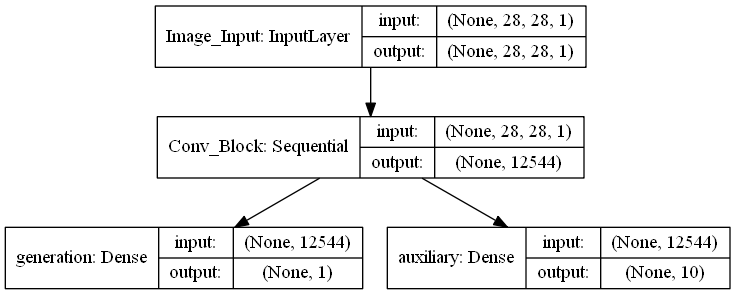

In [3]:
from keras.utils import plot_model
from keras.preprocessing import image

plot_model(discriminator, to_file='discriminator.png', show_shapes=True)
image.load_img('discriminator.png')

## Continued

For completeness, we'll look at the other portions that make up the GAN.

Being able to track the data dimensions between the images (Fake or Real) as well as class, and how they carry through the Generator was enormously helpful for me to understanding the construction of the Network as a whole.

In [4]:
latent_size = 128

generator = build_generator(latent_size)

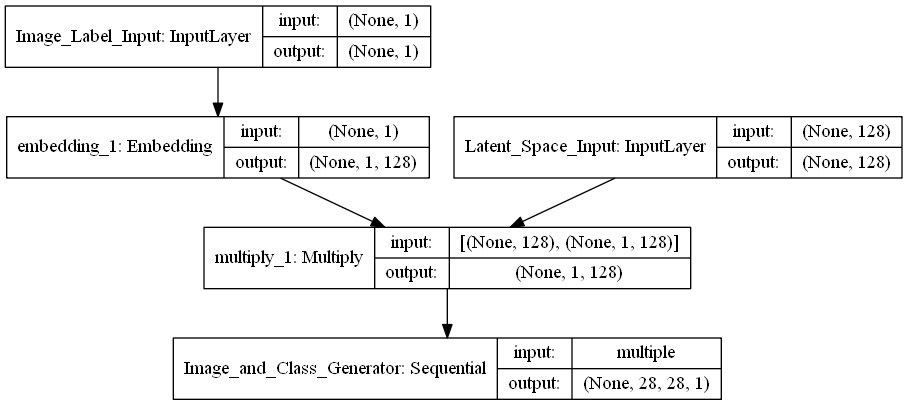

In [5]:
plot_model(generator, to_file='generator.png', show_shapes=True)
image.load_img('generator.png')

Similarly to how `Conv_Block` abstracts away all of the intermediate information, all you need to know about the overall structure of the `combined` Model that represents the whole GAN is that:

- It takes an image input and a class input
- It does some stuff
- The output of the final layer will be a True/False prediction and a Class prediction, chosen from 10

In [6]:
latent = Input(shape=(latent_size,), name='Image_Input')
image_class = Input(shape=(1,), dtype='int32', name='Image_Class')

fake = generator([latent, image_class])

discriminator.trainable = False
fake, aux = discriminator(fake)
combined = Model([latent, image_class], [fake, aux])

combined.compile(
    optimizer=Adam(),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy']
)
combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Image_Class (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 28, 28, 1)    2754945     Image_Input[0][0]                
                                                                 Image_Class[0][0]                
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 1), (None, 1 525835      model_2[1][0]                    
Total para

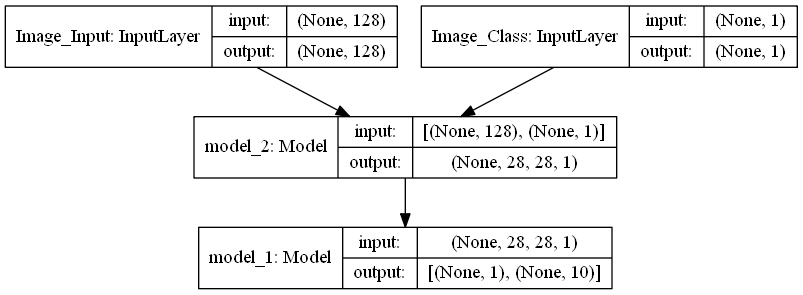

In [7]:
plot_model(combined, to_file='combined.png', show_shapes=True)
image.load_img('combined.png')

Ez pz